# Embeddings

In this notebook we work on the embeddings, by using the best results found in previous notebooks

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# input_file = "./your_beautiful_path_to_this_file_here_==>/ratings_BA.csv"
input_file = "./../../../../datasets/BeerAdvocate/ratings_BA.csv"
df = pd.read_csv(input_file)
df = df[df['review'] == True] # Consider only rows with review. .dropna() might drop rows we don't want.

model = SentenceTransformer('all-mpnet-base-v2')

## Focus on a specific beer

To better explore the data, we start by exploring a specific beer, beer_id = 11757. (other interesting beer = 2093)<br>
Being a stout with many reviews, we expect this beer to be interesting for this search.

We expect "good" reviewers to have a better understanding of such a beer, and find similar description of it.
We don't compare all the beers as there might be a beer that has less articulate flavours, while other are more nuanced.

In [3]:
# Take all the reviews of the target beer 
target_beer_id = 11757
df_target = df[df['beer_id'] == target_beer_id] # ? is copy necessary? [We don't get the warning anymore, if we use .copy()!]

# Get the embeddings for this group of reviews
embeddings_array = np.stack(df_target['text'].apply(lambda x: model.encode(x)).values)
df_embeddings = pd.DataFrame(embeddings_array)

# Concatenate the embeddings to the original DataFrame
df_target = pd.concat([df_target.reset_index(drop=True), df_embeddings], axis=1)

In [4]:
df_target.columns = pd.MultiIndex.from_tuples(
    [('embedding', i) if isinstance(i, int) else (i, '') for i in df_target.columns]
)

In [7]:
# Find expert users that have reviewed this beer
# By setting a threshold, consider experts reviewers with at least that number of reviews and non-experts the others
expert_th = 1000
not_expert_th = 50
 
df_users_nReviews = df.groupby(['user_id']).size()
experts = df_users_nReviews[df_users_nReviews >= expert_th]
not_experts = df_users_nReviews[df_users_nReviews <= not_expert_th]

df_experts = df_target[df_target['user_id'].isin(experts.index.tolist())]
df_non_experts = df_target[df_target['user_id'].isin(not_experts.index.tolist())]

In [8]:
exp_indexes = df_target[df_target['user_id'].isin(experts.index.tolist())].index
not_exp_indexes = df_target[df_target['user_id'].isin(not_experts.index.tolist())].index

In [9]:
# PCA
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(embeddings_array)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb_tsne = tsne.fit_transform(embeddings_array)

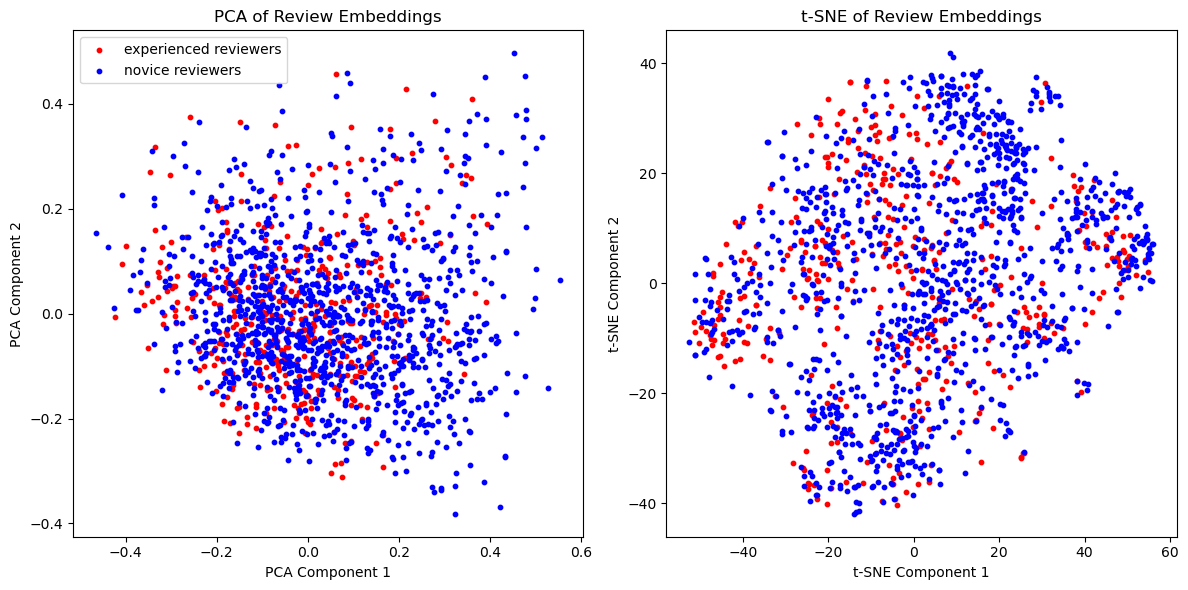

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot PCA result
plt.subplot(1, 2, 1)
plt.scatter(pca_emb[exp_indexes, 0], pca_emb[exp_indexes, 1], alpha=1, s=10, c='red', label='experienced reviewers')
plt.scatter(pca_emb[not_exp_indexes, 0], pca_emb[not_exp_indexes, 1], alpha=1, s=10, c='blue', label='novice reviewers')
plt.title('PCA of Review Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# Plot t-SNE result
plt.subplot(1, 2, 2)
plt.scatter(emb_tsne[exp_indexes, 0], emb_tsne[exp_indexes, 1], alpha=1, c='red', s=10, label='experienced reviewers')
plt.scatter(emb_tsne[not_exp_indexes, 0], emb_tsne[not_exp_indexes, 1], alpha=1, c='blue', s=10, label='novice reviewers')
plt.title('t-SNE of Review Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.tight_layout()
plt.show()